# How Different Types of Deep Learning Models Performs on Face MaskDetection
## Tianxue Hu, Chenjun Tang, Danrong Zhang
## CS7643 Final Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision as tv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from PIL import Image

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pickle
from tqdm.notebook import tqdm


# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32




# Image processing
#### Please go to the "save and load image" section if images have already processed!! 

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

imagePaths = list(paths.list_images('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/dataset'))
data = []
labels = []
image_num = len(imagePaths)
data_path = []
print("total number of images: ", image_num)

# loop over the image paths
for i, imagePath in enumerate(imagePaths):
  if i%1000 == 0:
    print("{}/{} images loaded".format(i, image_num))
  # extract the class label from the filename
  label = imagePath.split(os.path.sep)[-2]
  if label == 'with_mask':
    labels.append(0)
  else:
    labels.append(1)
  data_path.append(imagePath)

[INFO] loading images...
total number of images:  3846
0/3846 images loaded
1000/3846 images loaded
2000/3846 images loaded
3000/3846 images loaded


In [ ]:
#split into train, validation, and test sets
(trainX_path, testX_path, trainY, testY) = train_test_split(data_path, labels,	test_size=0.20, stratify=labels, random_state=42)
(trainX_path, valX_path, trainY, valY) = train_test_split(trainX_path, trainY,	test_size=0.25, stratify=trainY, random_state=42)


In [ ]:
# process image in training set based on paths
data_transform = tv.transforms.Compose(
    [
        tv.transforms.RandomResizedCrop(224),
        tv.transforms.Resize((224, 224)),
        tv.transforms.RandomHorizontalFlip(),
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

image_num = len(trainX_path)
train_data = []
for i, path in enumerate(trainX_path):
  if i%1000 == 0:
    print("{}/{} images processed".format(i, image_num))

  img = Image.open(path)
  img = img.convert('RGB')
  img = data_transform(img)
  train_data.append([img, trainY[i]])




0/2307 images processed


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


1000/2307 images processed
2000/2307 images processed


In [ ]:
#process image in validation set based on paths
image_num = len(valX_path)
val_data = []
for i, path in enumerate(valX_path):
  if i%1000 == 0:
    print("{}/{} images processed".format(i, image_num))
  img = Image.open(path)
  img = img.convert('RGB')
  img = data_transform(img)
  #img = torch.FloatTensor(img)
  #img = img.unsqueeze(0)
  val_data.append([img, valY[i]])

0/769 images processed


In [ ]:
#process image in test set based on paths
image_num = len(testX_path)
test_data = []
for i, path in enumerate(testX_path):
  if i%1000 == 0:
    print("{}/{} images processed".format(i, image_num))
  img = Image.open(path)
  img = img.convert('RGB')
  img = data_transform(img)
  #img = torch.FloatTensor(img)
  #img = img.unsqueeze(0)
  test_data.append([img, testY[i]])


0/770 images processed


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Save and load image

In [ ]:
#save processed datasets using pickle
'''
# Saving the train data:
with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)

# Saving the val data:
with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/val_data.pkl', 'wb') as f:
    pickle.dump(val_data, f)

# Saving the test data:
with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)
'''
# Get back the data:
with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/train_data.pkl', 'rb') as f: 
    train_data = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/test_data.pkl', 'rb') as f: 
    test_data = pickle.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Face_mask_detection/val_data.pkl', 'rb') as f: 
    val_data = pickle.load(f)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


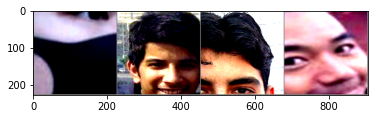

with mask without mask without mask without mask


In [ ]:
#dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val_data, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                          shuffle=True, num_workers=2)

classes = ('with mask', 'without mask')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(tv.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Model Training

In [ ]:
############################### Baseline Model ################################
# # model 1
# class MyModel(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(3, 6, 5)
#     self.pool = nn.MaxPool2d(2, 2)
#     self.conv2 = nn.Conv2d(6, 16, 5)
#     self.fc1 = nn.Linear(16*53*53, 120)
#     self.fc2 = nn.Linear(120, 84)
#     self.fc3 = nn.Linear(84, 2)

#   def forward(self, x):    
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x))) 
#     # print(x.shape) 
#     x = x.view(-1, 16*53*53)  
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

# model = MyModel()
# model.cuda()


############################### Resnet #######################################
# MODEL 2
# model = models.resnet18(pretrained=True)
# model.cuda()

# MODEL 3
# model = models.resnet34(pretrained=True)
# model.cuda()

# MODEL 4
# model = models.resnet50(pretrained=True)
# model.cuda()

# MODEL 5
# model = models.resnet101(pretrained=True)
# model.cuda()

# MODEL 6
# model = models.resnet152(pretrained=True)
# model.cuda()


############################### GoogleNet #######################################
# MODEL 7
#model = models.googlenet(pretrained=True)
#model.cuda()


############################### DenseNet #######################################
# MODEL 8
#model = models.densenet121(pretrained=True)
#model.cuda()

# MODEL 9
#model = models.densenet169(pretrained=True)
#model.cuda()

# MODEL 10
#model = models.densenet201(pretrained=True)
#model.cuda()

# MODEL 11
#model = models.densenet161(pretrained=True)
#model.cuda()


############################### VGG #######################################
# MODEL 12
#model = models.vgg11(pretrained=True)
#model.cuda()

# MODEL 13
#model = models.vgg11_bn(pretrained=True)
#model.cuda()

# MODEL 14
model = models.vgg16(pretrained=True)
model.cuda()

# MODEL 15
#model = models.vgg16_bn(pretrained=True)
#model.cuda()

# MODEL 16
#model = models.vgg19(pretrained=True)
#model.cuda()

# MODEL 17
#model = models.vgg19_bn(pretrained=True)
#model.cuda()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [ ]:
epochs = 10
train_losses = []
val_losses = []
for epoch in range(1, epochs+1):  
    print("Epoch:", epoch)
    total_loss = 0.0
    model.train()
    train_pgbar = tqdm(trainloader)
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_pgbar.set_postfix({'Epoch': epoch, 'Train Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Training Loss: %.2f" % total_loss)
    train_losses.append(total_loss/len(trainloader))
    total_loss = 0

    model.eval()
    val_pgbar = tqdm(valloader)
    for i, data in enumerate(val_pgbar):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        loss= criterion(outputs, labels)

        val_pgbar.set_postfix({'Epoch': epoch, 'Val Loss': "{:.5f}".format(loss.item())})
        total_loss += loss.item()
    print("Total Validation Loss: %.2f" % total_loss)
    val_losses.append(total_loss/len(valloader))

print('Finished Training')

Epoch: 1


Total Training Loss: 270.48



Total Validation Loss: 27.85
Epoch: 2


Total Training Loss: 64.43



Total Validation Loss: 31.12
Epoch: 3


Total Training Loss: 44.50



Total Validation Loss: 27.13
Epoch: 4


Total Training Loss: 30.80



Total Validation Loss: 27.04
Epoch: 5


Total Training Loss: 28.22



Total Validation Loss: 31.74
Epoch: 6


Total Training Loss: 14.72



Total Validation Loss: 27.35
Epoch: 7


Total Training Loss: 8.83



Total Validation Loss: 29.25
Epoch: 8


Total Training Loss: 12.53



Total Validation Loss: 28.26
Epoch: 9


Total Training Loss: 7.96



Total Validation Loss: 30.54
Epoch: 10


Total Training Loss: 12.17



Total Validation Loss: 29.97
Finished Training


# Model evaluations

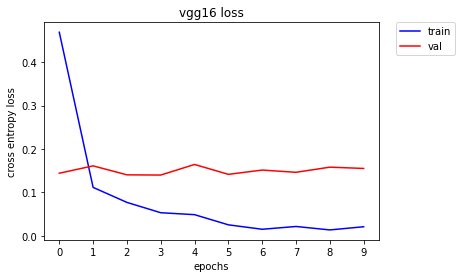

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(train_losses, color = "b", label = "train")
plt.plot(val_losses, color = "r", label = "val")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_xlabel('epochs')
ax.set_ylabel('cross entropy loss') 
xint = range(len(train_losses))

plt.xticks(xint)
plt.title("vgg16 loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


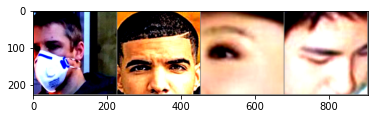

GroundTruth:  with mask without mask without mask without mask
Predicted:  with mask without mask without mask without mask


In [ ]:
# test the model - example

dataiter = iter(testloader)
test_images, gt_labels = dataiter.next()

# print images
imshow(tv.utils.make_grid(test_images))
print('GroundTruth: ', ' '.join('%5s' % classes[gt_labels[j]] for j in range(4)))

test_images = test_images.cuda()
#gt_labels = gt_labels.cuda()
output = model(test_images)
predicted = output.cpu().detach().numpy().argmax(axis = 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
# test the whole test set

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 96 %


In [ ]:
# test the whole train set

correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 99 %
